In [45]:
import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'ieee'])

c = 2 # damping constant
k = 5 # spring constant
m = 20 # load mass
# F = 0 # external force

def function(t):
    d = c / (2 * m)
    w0 = np.sqrt(k / m)

    # x(t) = exp^(-d * t) * (2A * cos(phi + w * t))
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1 / (2 * np.cos(phi))
    x = (np.exp(-d * t)) * (2 * A * np.cos(phi + w * t))
    return x

# DATA PROCESSING
# generate full dataset
t_full = np.arange(0, 101, 0.1)
x_full = function(t_full)
# Randomly extract 25 points from the function until t = 20
t_train = np.arange(0, 21, 0.1)
random_indices = np.random.choice(len(t_train), 25, replace=False)
t_train = t_full[random_indices]
x_train = x_full[random_indices]

Epoch [100/1000], Loss: 0.0052
Epoch [200/1000], Loss: 0.0008
Epoch [300/1000], Loss: 0.0004
Epoch [400/1000], Loss: 0.0015
Epoch [500/1000], Loss: 0.0012
Epoch [600/1000], Loss: 0.0007
Epoch [700/1000], Loss: 0.0003
Epoch [800/1000], Loss: 0.0002
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0002


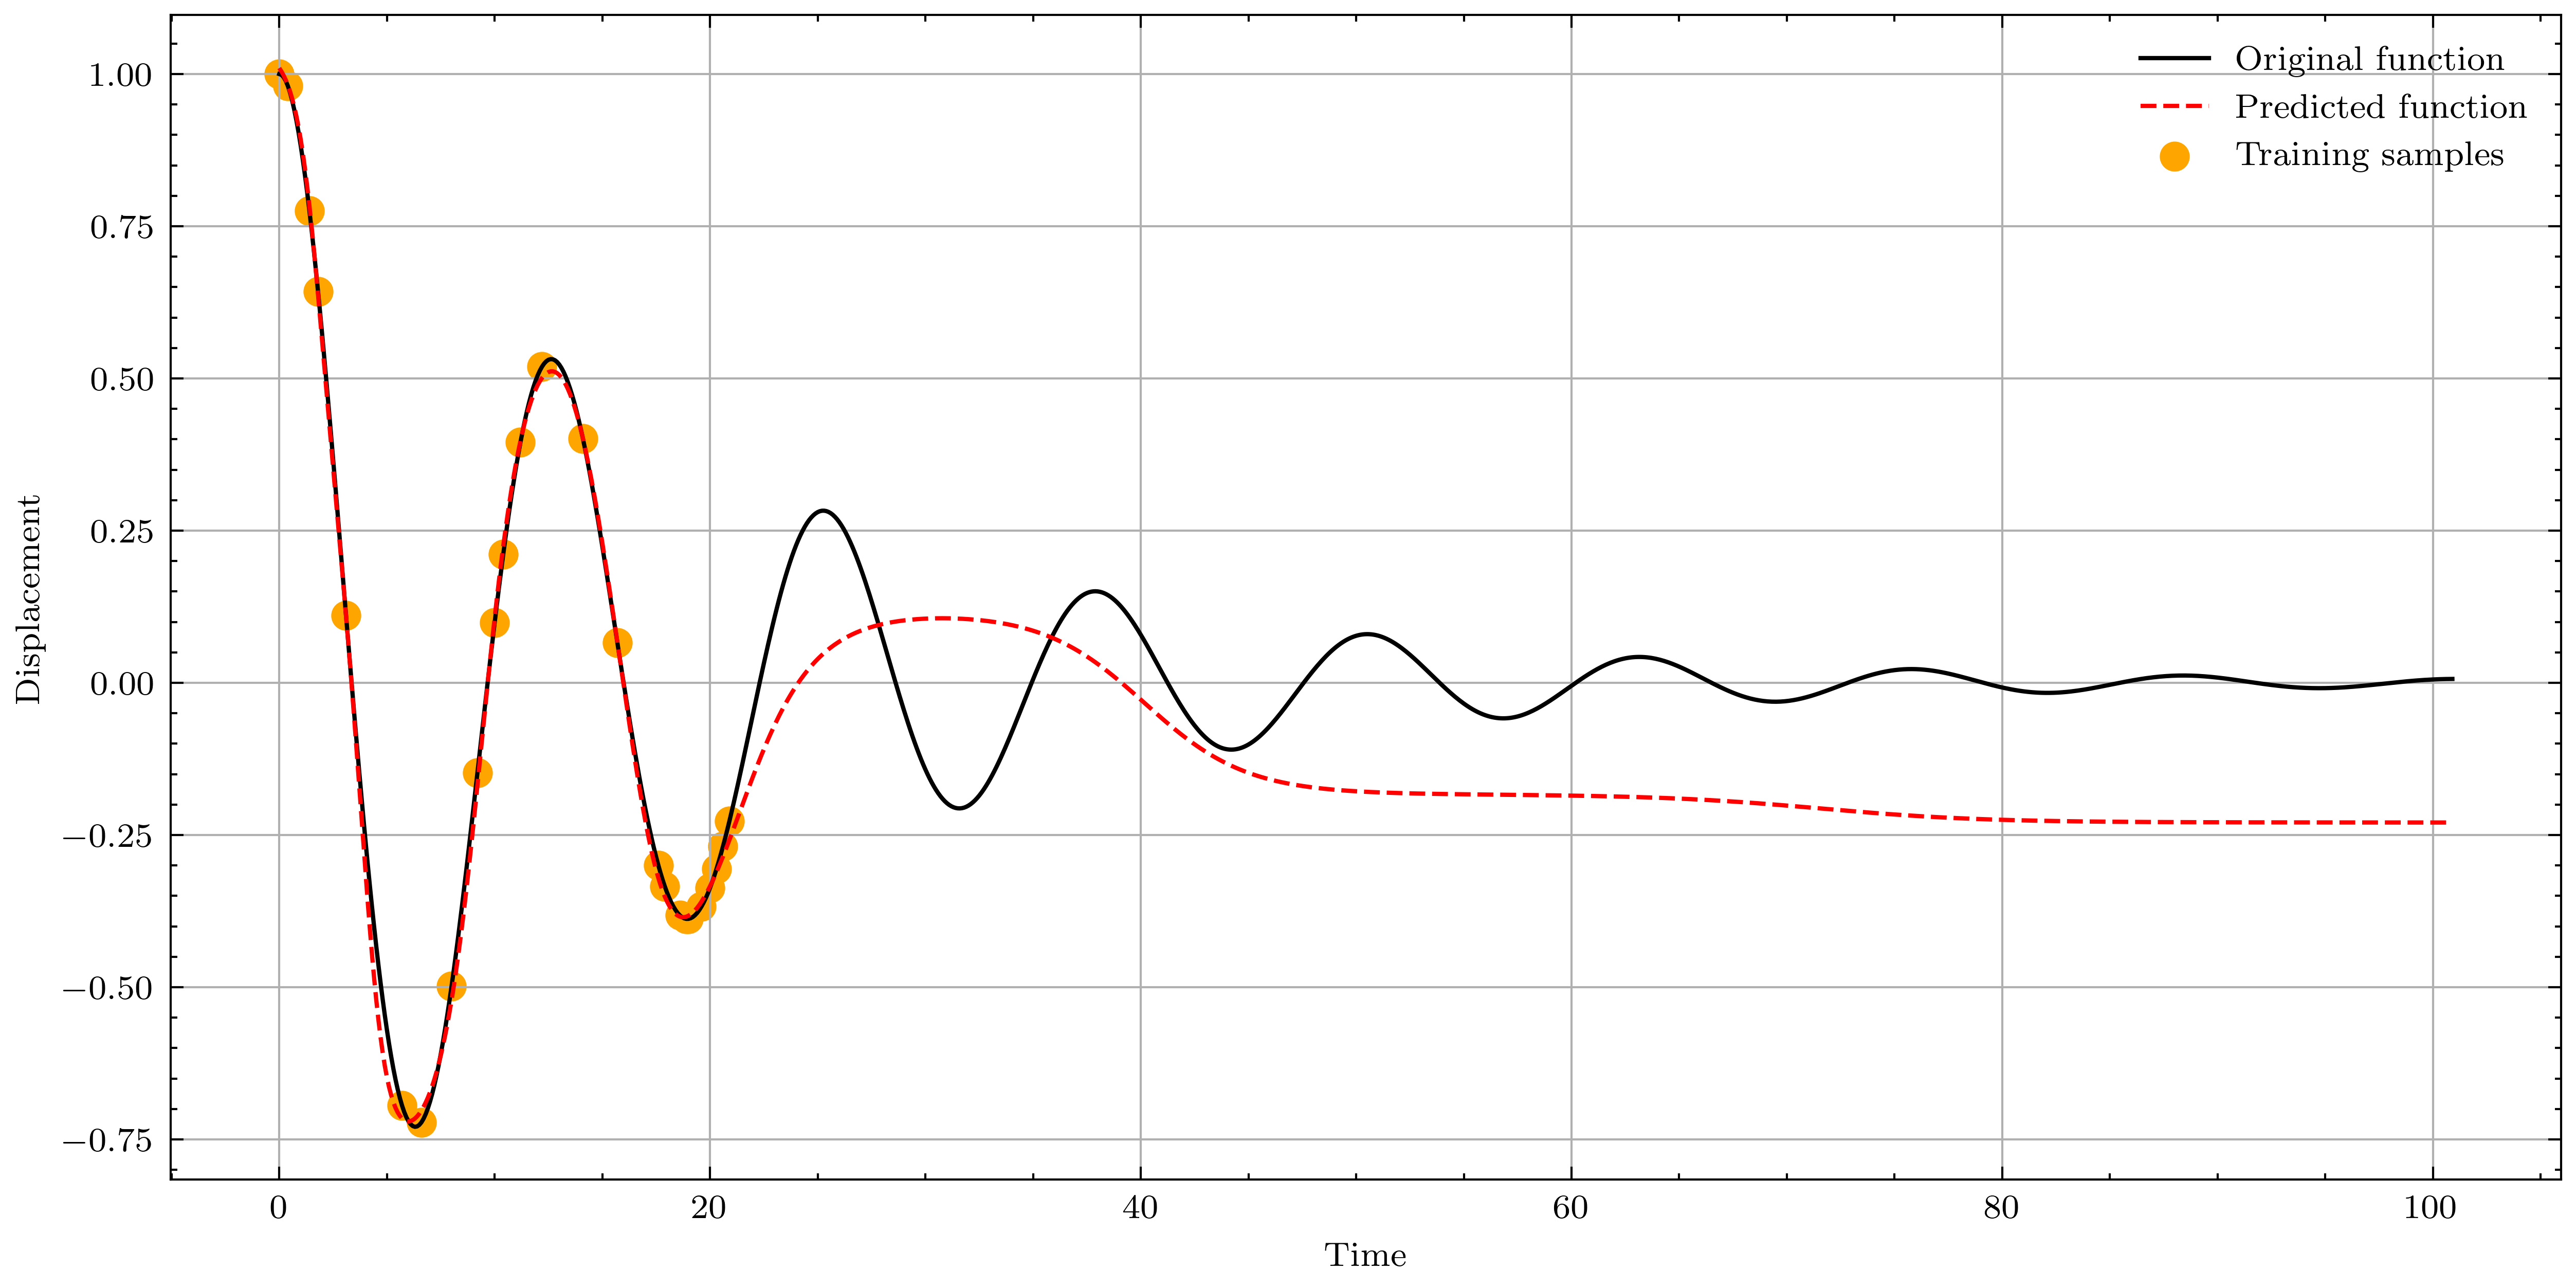

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class FCNN(nn.Module):
    '''
    Define neural network architecture
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN), activation()
        ])
        
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN), activation()
            ]) for _ in range(N_LAYERS)
        ])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Convert the training data to PyTorch tensors
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).unsqueeze(1)
k_train_tensor = torch.tensor([k] * len(t_train), dtype=torch.float32).unsqueeze(1)  # Constant value for k
c_train_tensor = torch.tensor([c] * len(t_train), dtype=torch.float32).unsqueeze(1)  # Constant value for c
m_train_tensor = torch.tensor([m] * len(t_train), dtype=torch.float32).unsqueeze(1)  # Constant value for m
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)

# Concatenate the input tensors
inputs = torch.cat((t_train_tensor, k_train_tensor, c_train_tensor, m_train_tensor), dim=1)

# Create an instance of the neural network model
model = FCNN(4, 1, 32, 8)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the neural network
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, x_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generate predictions for the full dataset
t_full_tensor = torch.tensor(t_full, dtype=torch.float32).unsqueeze(1)
k_full_tensor = torch.tensor([k] * len(t_full), dtype=torch.float32).unsqueeze(1)  # Constant value for k
c_full_tensor = torch.tensor([c] * len(t_full), dtype=torch.float32).unsqueeze(1)  # Constant value for c
m_full_tensor = torch.tensor([m] * len(t_full), dtype=torch.float32).unsqueeze(1)  # Constant value for m
full_inputs = torch.cat((t_full_tensor, k_full_tensor, c_full_tensor, m_full_tensor), dim=1)

with torch.no_grad():
    predictions = model(full_inputs).numpy()

# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_full, x_full, label='Original function')
ax.plot(t_full, predictions, label='Predicted function')
ax.scatter(t_train, x_train, color='orange', label='Training samples')
# ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
plt.show()
